# 3D Affine Variational Autoencoder

Add optimization of rotations and translations into the VAE, done before each forward pass

**Goal: Show that this optimization results in lower reconstruction loss, and that is gives a more disentangled representation of orientation and shape**

In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import kaolin as kal
from kaolin.datasets import ModelNet, ModelNetVoxels

from models import *
from dataset.trans_model_net_voxels import TransformedModelNetVoxels
from utils_3d import pad_for_transform, make_affine #affine_transform, get_affine_matrix

%reload_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda:0'
modelnet_path = './data/ModelNet10'

In [2]:
import math
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.nn import functional as F

class AVAE3d(nn.Module):
    def __init__(self, VAE, opt_method='all_90_rot'):
        super(AVAE3d, self).__init__()
        assert opt_method in ['none', 'all_90_rot', 'rand_sgd_rot', 'rand_sgd_rot_trans']
        self.VAE = VAE
        self.opt_method = opt_method
        if self.opt_method == 'all_90_rot':
            self.all_90_rot = self.get_all_rot_mat()
            
    def get_all_rot_mat(self):
        def rot90_x(mat): return torch.mm(torch.FloatTensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]]), mat)
        def rot90_y(mat): return torch.mm(torch.FloatTensor([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]), mat)
        mat = torch.zeros(3, 4)
        mat[:, :3] = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        all_rotations = []
        for cycle in range(2):
            for step in range(3):
                mat[:, :3] = rot90_x(mat[:, :3])
                all_rotations.append(mat.clone())
                for i in range(3):
                    mat[:, :3] = rot90_y(mat[:, :3])
                    all_rotations.append(mat.clone())
            mat[:, :3] = rot90_x(rot90_y(rot90_x(mat[:, :3])))
        return torch.stack(all_rotations)
            
        
    def affine(self, x, affine_params, padding_mode='zeros'):
        grid = F.affine_grid(affine_params, x.size(), align_corners=False).to(x.device)
        x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
        return x
    
    def affine_inv(self, x, affine_params, padding_mode='zeros'):
        print('affine_params.size()', affine_params.size())
        if self.opt_method in ['all_90_rot', 'rand_sgd_rot'] or : # inverse is transpose if rot
            zeros = torch.FloatTensor(affine_params.size()[:, :, 1]).fill_(0).to(x.device)
                inv_affine_params[:, :, :3] = torch.cat([torch.transpose(affine_params[:, :, :3], 1, 2), 
                                                        zeros])
            print('zeros.size()', zeros.size())
            print('inv_affine_params.size()', inv_affine_params.size())
        else:
            pass
        grid = F.affine_grid(inv_affine_params, x.size(), align_corners=False).to(x.device)
        x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
        return x
    
    
    def forward(self, x, deterministic=False):
        if self.opt_method=='none': # affine is identity
            affine_params = torch.zeros(3, 4).to(x.device)
            affine_params[:, :3] = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            affine_params = affine_params.unsqueeze(0).repeat(x.size(0), 1, 1).to(x.device)
            recon_x, mu = self.affine_forward(x, affine_params=affine_params, deterministic=deterministic)
        elif self.opt_method=='all_90_rot':
            recon_x, mu, loss, affine_params = self.forward_best_90_rot(x, deterministic=True)
            # Shouldn't need this:
            recon_x, mu = self.affine_forward(x, affine_params=affine_params, deterministic=False)
        elif 'rand_sgd' in self.opt_method:
            recon_x, mu, loss, affine_params = self.forward_opt(x, deterministic=True, n_sgd=4, n_total_affine=16)
            recon_x, mu = self.affine_forward(x, affine_params=affine_params, deterministic=False)          
        return {'recon_x':recon_x, 
                'mu': mu,
                'affine_params': affine_params}
        
        
    def affine_forward(self, x, affine_params=None, deterministic=False):
        x_affine = self.affine(x, affine_params)
        mu = self.VAE.encode(x_affine)
        z = self.VAE.reparameterize(mu, deterministic)
        recon_x = self.VAE.decode(z)
        recon_x = self.affine_inv(recon_x, affine_params)
        return recon_x, mu

    
    def forward_best_90_rot(self, x, deterministic=True):
        """ Try all 24 rotations.
        
        Loss for all afffine params and imgs in parallel. 
        Duplicate imgs & params since can only apply one affine per img.
        returns: loss, affine_params(3x4)
        """                                
        with torch.no_grad():
            affine_params = self.all_90_rot.clone().detach().to(x.device) # be safe
            bs, ch, _, _, _ = x.size()
            n_affine, _, _ = affine_params.size()
            x_repeated = x.repeat(n_affine, 1, 1, 1, 1)
            affine_params_repeat = affine_params.repeat(bs, 1, 1).view(bs*n_affine, 3, 4).to(x.device)

            recon_x, mu = self.affine_forward(x_repeated, affine_params=affine_params_repeat, deterministic=deterministic)
            loss = self.vae_loss_unreduced((recon_x, mu), x_repeated)
            loss = loss.view(n_affine, bs, 1)
            best_loss, best_param_idx = torch.min(loss, dim=0)

            # select the params, recon_x, mu corresponding to lowest loss
            mu = mu.view(n_affine, bs, -1)
            affine_params_repeat = affine_params_repeat.view(n_affine, bs, 3, 4)
            recon_x = recon_x.view(n_affine, bs, 1, recon_x.size(-3), recon_x.size(-2), recon_x.size(-1))
            recon_x_best = recon_x[best_param_idx.squeeze(), torch.arange(bs), :, :, :, :]
            mu_best = mu[best_param_idx.squeeze(), torch.arange(bs), :]

            best_affine_params = affine_params_repeat[best_param_idx.squeeze(), torch.arange(bs), :, :]
        return recon_x_best, mu_best, best_loss, best_affine_params

    def forward_opt(self, x, deterministic=True, n_sgd=4, n_total_affine=16):
        """ BS=1 !
        n_affine is number of random restarts
        """
        bs, ch, _, _, _ = x.size()
        assert bs==1
        r_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
        if 'trans' in self.opt_method:
            t_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
        else:
            t_init = None

        with torch.no_grad():
            affine_params = make_affine(r=r_init, t=t_init, device=x.device)
            x_rep = x.repeat(n_total_affine, 1, 1, 1, 1)
            recon_x, mu = self.affine_forward(x_rep, affine_params=affine_params, deterministic=deterministic)
            loss = self.vae_loss_unreduced((recon_x, mu), x_rep)
            best_loss, best_param_idx = torch.topk(loss, k=n_sgd, largest=False)
            
        # SGD TIME - Select best params and get rid of old params so no grad or memory issues
        del recon_x, mu, x_rep
        r_init = r_init[best_param_idx, :].clone().detach().requires_grad_(True)
        if 'trans' in self.opt_method:
            t_init = t_init[best_param_idx, :].clone().detach().requires_grad_(True)
        else:
            t_init = None
        x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
        
        optimizer = optim.Adam([r_init, t_init], lr=.03)
        for i in range(20):
            affine_params = make_affine(r=r_init, t=t_init, device=x.device)
            recon_x, mu = self.affine_forward(x_rep, affine_params=affine_params, deterministic=deterministic)
            loss = self.vae_loss_unreduced((recon_x, mu), x_rep)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        recon_x, mu = self.affine_forward(x_rep, affine_params=affine_params, deterministic=deterministic)
        loss = self.vae_loss_unreduced((recon_x, mu), x_rep)
        best_loss, best_idx = torch.min(loss, dim=0)
        return recon_x[best_idx, :, :, :], mu[best_idx, :], best_loss, best_affine_params
            

    def vae_loss_unreduced(self, output, x, KLD_weight=1):
        recon_x, mu  = output
        BCE = F.binary_cross_entropy(recon_x.squeeze(), x.squeeze(), reduction='none')
        BCE = torch.sum(BCE, dim=(1, 2, 3))
        KLD = -0.5 * torch.sum(1 + 0 - mu.pow(2) - 1)
        return BCE + KLD_weight*KLD

    

SyntaxError: invalid syntax (<ipython-input-2-dd738ec8370b>, line 43)

## Affine Transforms

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 31881.30it/s]


KeyboardInterrupt: 

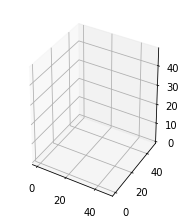

In [4]:
affine_objectives = [
    {'rot': [math.pi/6, math.pi/6, 0],
     'trans': [.1, .1, 0]},
    {'rot': [-math.pi/6, -math.pi/6, -math.pi/6],
     'trans': [-.1, -.1, -.1]},
]
get_affine_matrix

modelnet_path = './data/ModelNet10'
categories = ['dresser']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=1)
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

visualize_affine_opt(x, affine_objectives, device)

## Optimization with Random Restarts
Above results show that differentiable optimization works resonably well, but inconsistently:
* Better for simple shapes (dresser vs. table)
* Better for translations than rotations
* Limited to smaller rotations (<45 degrees)

Because of this we need to use another method to ensure the optimization isn't caught in a local optimum. 

Note there's a bunch of better ways to do optimization, but we choose something simple. We want it to be easily parallelizable. It's relatively fast to a forward pass on a bunch of parameters, but slow to do things sequentially. So we'll randomly sample n_rand parameters, and do SGD on the top n_sgd of them.

In [11]:
categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 
                   'sofa', 'monitor', 'table', 'toilet', 'bed']

results = pd.DataFrame()
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

for n_affine in [4, 16, 64, 256]:
    for category in categories:
        trainset = ModelNetVoxels(modelnet_path, categories=[category], resolutions=[32],
                                   split='train', device=device)
        train_loader = DataLoader(trainset, batch_size=1)
        category_results = {}
        category_results['category'] = category
        for affine_idx, affine_dict in enumerate(affine_objectives):
            total_loss = 0
            for batch in train_loader:
                x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                x_goal = affine_transform(x_pad, affine_mat=get_affine_matrix(**affine_dict))
                loss, affine_params = rand_opt(x_pad, x_goal, n_affine=n_affine)
                total_loss += loss.item()
            category_results[affine_idx] = total_loss/len(train_loader)
        results = results.append(category_results, ignore_index=True)
    print(f'{n_affine} random restarts, average loss: {np.mean(results.values[:, :3])}')

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 31784.66it/s]


KeyboardInterrupt: 

## Random Restarts + SGD
* Above result shows random restarts is working.
* Do gradient descent on the best random restarts

In [15]:
def rand_sgd_opt(x, x_goal, n_sgd=4, n_total_affine=16):
    """ BS=1 !
    n_affine is number of random restarts
    """
    bs, ch, _, _, _ = x.size()
    assert bs==1
    r_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
    t_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
    
    with torch.no_grad():
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        
        # repeat in batch dim, so bs*n_affine:
        x_rep = x.repeat(n_total_affine, 1, 1, 1, 1)
        xg_rep = x_goal.repeat(n_total_affine, 1, 1, 1, 1)

        # "forward pass", and sum loss per example
        x_affine = affine_transform(x_rep, affine_params)
        loss = F.mse_loss(x_affine, xg_rep, reduction='none')
        loss = loss.sum((-3, -2, -1)).squeeze()
        best_loss, best_param_idx = torch.topk(loss, k=n_sgd, largest=False)
        
    # SGD TIME - Select best params and get rid of old params so no grad or memory issues
    del x_affine, x_rep, xg_rep
    r_init = r_init[best_param_idx, :].clone().detach().requires_grad_(True)
    t_init = t_init[best_param_idx, :].clone().detach().requires_grad_(True)
    
    x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
    xg_rep = x_goal.repeat(n_sgd, 1, 1, 1, 1)
    optimizer = optim.Adam([r_init, t_init], lr=.01)

    for i in range(25):
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        x_affine = affine_transform(x_rep, affine_params)        
        loss = F.mse_loss(x_affine, xg_rep, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = F.mse_loss(x_affine, xg_rep, reduction='none')
    loss = loss.sum((-3, -2, -1)).squeeze()
    best_loss, best_param_idx = torch.min(loss, dim=0)
#     print('final best loss: ', best_loss.item())
    return best_loss, affine_params[best_param_idx, :, :]

In [14]:
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

__BS = 4

categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 'sofa', ]#'monitor', 'table', 'toilet', 'bed']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                           split='train', device=device)
train_loader = DataLoader(trainset, batch_size=__BS)

n_sgd_list = [2, 4, 8, 16]
n_total_affine_list = [16, 32, 64]
results = pd.DataFrame(columns=n_sgd_list, index=n_total_affine_list)

for n_total_affine in n_total_affine_list:
    for n_sgd in n_sgd_list:
        if n_total_affine < n_sgd: 
            continue
            
        total_loss = 0
        for affine_idx, affine_dict in enumerate(affine_objectives):
            for batch in train_loader:
                x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                x_goal = affine_transform(x_pad, affine_mat=get_affine_matrix(**affine_dict))
                loss, affine_params = rand_sgd_opt(x_pad, x_goal, n_sgd=n_sgd, n_total_affine=n_total_affine)
                total_loss += loss.item()
        results.at[n_sgd, n_total_affine] = total_loss/len(train_loader)
        print(f'Inits: {n_total_affine}, SGD on top {n_sgd}, average loss: {total_loss/len(train_loader)}')
results

converting to voxels to resolution 32: 100%|██████████| 2275/2275 [00:00<00:00, 30464.44it/s]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [74]:
def rand_sgd_opt_batch(x, x_goal, n_sgd=4, n_total_affine=16):
    """
    n_affine is number of random restarts
    """
    bs, ch, _, _, _ = x.size()
    r_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
    t_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
    
    with torch.no_grad():
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        
        # repeat in batch dim, so bs*n_affine:
        x_rep = x.repeat(n_total_affine, 1, 1, 1, 1)
        xg_rep = x_goal.repeat(n_total_affine, 1, 1, 1, 1)
        affine_params_rep = affine_params.repeat(bs, 1, 1).view(bs*n_total_affine, 3, 4).to(x.device)
        
        # "forward pass", and get loss per example
        x_affine = affine_transform(x_rep, affine_params_rep)
        loss = F.mse_loss(x_affine, xg_rep, reduction='none')
        loss = loss.sum((-3, -2, -1)).squeeze()
        loss = loss.view(n_total_affine, bs)
        
        best_loss, best_param_idx = torch.topk(loss, dim=0, k=n_sgd, largest=False)
        affine_params_rep = affine_params_rep.view(n_total_affine, bs, 3, 4)
        best_affine_params = affine_params_rep[best_param_idx, torch.arange(bs), :, :]
        best_affine_params = best_affine_params.view(n_sgd*bs, 3, 4)
        
    # SGD TIME - Get rid of old params and re-create so no grad or memory issues
    affine_params = best_affine_params.clone().detach().requires_grad_(True)
    del best_affine_params, x_affine, x_rep, xg_rep, r_init, t_init
    x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
    xg_rep = x_goal.repeat(n_sgd, 1, 1, 1, 1)
    optimizer = optim.Adam([affine_params], lr=.03)

    for i in range(20):
        x_affine = affine_transform(x_rep, affine_params)        
        loss = F.mse_loss(x_affine, xg_rep, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = F.mse_loss(x_affine, xg_rep, reduction='none')
    loss = loss.sum((-3, -2, -1)).squeeze()
    best_loss, best_param_idx = torch.min(loss, dim=0)
    return best_loss, affine_params[best_param_idx, :, :]

In [75]:
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

bs = 4

categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 'sofa', ]#'monitor', 'table', 'toilet', 'bed']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                           split='train', device=device)
train_loader = DataLoader(trainset, batch_size=bs)

n_sgd_list = [2, 4, 8, 16]
n_total_affine_list = [16, 32, 64]
results = pd.DataFrame(columns=n_sgd_list, index=n_total_affine_list)

for n_total_affine in n_total_affine_list:
    for n_sgd in n_sgd_list:
        if n_total_affine < n_sgd: 
            continue
        total_loss = 0
        for affine_idx, affine_dict in enumerate(affine_objectives):
            for batch in train_loader:
                x = batch['data']['32'].to(device).unsqueeze(1)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                if x_pad.size() != torch.Size([bs, 1, 48, 48, 48]):
                    print(x.size(), x_pad.size())
                affine_mat = get_affine_matrix(**affine_dict).repeat(bs, 1, 1)
                x_goal = affine_transform(x_pad, affine_mat=affine_mat)
                loss, affine_params = rand_sgd_opt_batch(x_pad, x_goal, n_sgd=n_sgd, n_total_affine=n_total_affine)
                total_loss += loss.item()
        results.at[n_sgd, n_total_affine] = total_loss/len(train_loader)
        print(f'Inits: {n_total_affine}, SGD on top {n_sgd}, average loss: {total_loss/len(train_loader)}')
results

converting to voxels to resolution 32: 100%|██████████| 2275/2275 [00:00<00:00, 29641.95it/s]


torch.Size([3, 1, 32, 32, 32]) torch.Size([3, 1, 48, 48, 48])


RuntimeError: Expected tensor to have size 3 at dimension 0, but got size 4 for argument #2 'batch2' (while checking arguments for bmm)